## Student Identity
Name: Arman Lotfalikhani <br>
Student Number: 99109166

In [1]:
import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.models import alexnet, AlexNet_Weights
from torch.utils.data import DataLoader
import torch.nn as nn

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

In [2]:
train_set = CIFAR10(root='.', train=True, download=True, transform=transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor()]))
test_set = CIFAR10(root='.', train=False, download=True, transform=transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor()]))


train_targets=np.array(train_set.targets)
test_targets=np.array(test_set.targets)

train_mask=(train_targets==0) | (train_targets==1)
test_mask=(test_targets==0) | (test_targets==1)

train_set.targets=train_targets[train_mask].tolist()
train_set.data=train_set.data[train_mask]

test_set.targets=test_targets[test_mask].tolist()
test_set.data=test_set.data[test_mask]

image_shape = train_set[0][0].shape
input_dim = np.prod(image_shape).item() 
num_classes=2


Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alex_model=alexnet(weights=AlexNet_Weights.IMAGENET1K_V1, progress=True)

In [4]:
for p in alex_model.features.parameters():
    p.requires_grad=False
for m in alex_model.classifier.named_modules():
    if hasattr(m,'reset_parameters'):
        m.reset_parameters()
alex_model.classifier[6]=nn.Linear(in_features=4096, out_features=2, bias=True)
n=len(train_set.targets)
n_test=len(test_set.targets)
print('Number of train set samples', n,'Number of test set samples', n_test)

Number of train set samples 10000 Number of test set samples 2000


In [5]:
loss_func=nn.CrossEntropyLoss()
gpu_alex_model=alex_model.to(device)
optimizer=torch.optim.Adam(gpu_alex_model.parameters())
trainloader = DataLoader(train_set, 128, shuffle=True)
testloader = DataLoader(test_set, 64, shuffle=True)

In [6]:
epoch_nums = 5## Number of epochs
train_loss_list=[]
train_acc_list=[]
for epoch in range(epoch_nums):  # loop over the dataset multiple times
    gpu_alex_model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        images=data[0].to(device)
        my_classes=data[1].to(device)
        
        logits=gpu_alex_model(images)
        loss=loss_func(logits,my_classes)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss=running_loss+loss.item()/len(trainloader)
    
    gpu_alex_model.eval()
    correct=0
    total=0
    with torch.no_grad():
        for data in trainloader:
            images=data[0].to(device)
            labels=data[1].to(device)
            predictions=torch.argmax(gpu_alex_model(images),1)
            correct+=torch.sum(torch.eq(predictions,labels)).item()
            total+=len(predictions)
    train_acc_list.append(correct/total)
    print(correct/total)

    print("Epoch: %i Running loss: %f"%(epoch+1,running_loss))
    train_loss_list.append(running_loss)

print('Finished Training')

0.9335
Epoch: 1 Running loss: 0.321545
0.9689
Epoch: 2 Running loss: 0.118425
0.9715
Epoch: 3 Running loss: 0.104260
0.9763
Epoch: 4 Running loss: 0.089494
0.96
Epoch: 5 Running loss: 0.077439
Finished Training


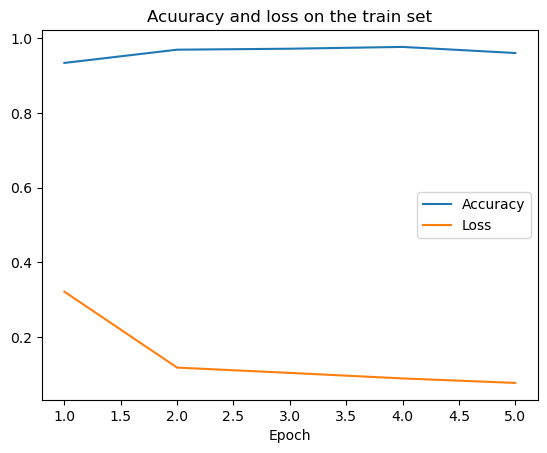

In [11]:
plt.title('Accuracy and loss on the train set')
plt.plot(np.arange(1,epoch_nums+1),train_acc_list,label='Accuracy')
plt.plot(np.arange(1,epoch_nums+1),train_loss_list,label='Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [12]:
correct = 0
total = 0

gpu_alex_model.eval()
with torch.no_grad():
    for data in testloader:
        images=data[0].to(device)
        labels=data[1].to(device)
        predictions=torch.argmax(gpu_alex_model(images),1)
        correct+=torch.sum(torch.eq(predictions,labels)).item()
        total+=len(predictions)

print(f'Accuracy of the network on the 2000 test images: {100 * correct / total} %')

Accuracy of the network on the 2000 test images: 94.6 %


## Triplet loss training on the convolutional section

Explanation on the dataset class: In the constructor, first the dataset is reduced to two classes using a mask. After that, we extract the two sets for both labels. <br>
For the triplet loss, first we determine the label of the datapoint (given by idx in __getitem__), use it as the anchor, and sample randomly from the dataset for the positive and negative outputs, based on the anchor label.


In [5]:
from PIL import Image

class triplet_loss_cifar10_two_class(CIFAR10):
    def __init__(self, label1, label2, train,download,transform,device):
        super().__init__(root='.', train=train, download=download, transform=transform)
        targets=np.array(self.targets)
        mask=(targets==label1) | (targets==label2)
        self.targets=targets[mask].tolist()
        reduced_targets=targets[mask]
        self.data=self.data[mask]
        self.rng=np.random.default_rng(100)
        
        self.transform=transform
        self.device=device
        
        self.label_map={label1:0,label2:1}
        
        mask2=(reduced_targets==label1)
        self.sets=(self.data[mask2],self.data[~mask2])       
        self.lens=(len(self.sets[0]), len(self.sets[1]))
        self.nptargets=(reduced_targets[mask2],reduced_targets[~mask2])
        return
    def __getitem__(self,idx):
        im, label = super().__getitem__(idx)

        bin_label=self.label_map[label]
        pos_idx=self.rng.integers(self.lens[bin_label])
        neg_idx=self.rng.integers(self.lens[1-bin_label])
        
        pos_label=self.nptargets[bin_label][pos_idx]
        neg_label=self.nptargets[1-bin_label][neg_idx]

        pos=self.transform(Image.fromarray(self.sets[bin_label][pos_idx]))
        neg=self.transform(Image.fromarray(self.sets[1-bin_label][neg_idx]))
        
        anchor=im
        anchor_label=label
        return anchor, pos, neg, anchor_label, pos_label, neg_label
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
triplet_train=triplet_loss_cifar10_two_class(label1=0, label2=1, train=True, download=True, device=device, 
                                             transform=transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor()]))

Files already downloaded and verified


In [14]:
alex_model2=alexnet(weights=AlexNet_Weights.IMAGENET1K_V1, progress=True)
for m in alex_model2.classifier.named_modules():
    if hasattr(m,'reset_parameters'):
        m.reset_parameters()
alex_model2.classifier[6]=nn.Linear(in_features=4096, out_features=2, bias=True)
cross_entropy2=nn.CrossEntropyLoss()
triplet_loss1=nn.TripletMarginLoss()
gpu_alex_model2=alex_model2.to(device)
triplet_optimizer1=torch.optim.Adam(gpu_alex_model2.features.parameters())
cross_entropy_optimizer2=torch.optim.Adam(gpu_alex_model2.classifier.parameters())
triplet_loader1 = DataLoader(triplet_train, 128, shuffle=True)

In [15]:
epoch_nums = 5 ## Number of epochs
train_loss_list=[]
for epoch in range(epoch_nums):  # loop over the dataset multiple times
    gpu_alex_model2.train()
    running_loss = 0.0
    for i, data in enumerate(triplet_loader1, 0):
        (anchor, pos, neg, anchor_label, pos_label, neg_label)=data
        
        pos_out=gpu_alex_model2.features.forward( (pos.to(device)) ) 
        neg_out=gpu_alex_model2.features.forward( (neg.to(device)) )
        anchor_out=gpu_alex_model2.features(anchor.to(device))
        loss=triplet_loss1(anchor_out.flatten(start_dim=1),pos_out.flatten(start_dim=1),neg_out.flatten(start_dim=1))
        
        loss.backward()
        triplet_optimizer1.step()
        triplet_optimizer1.zero_grad()
        
        running_loss=running_loss+loss.item()/len(triplet_loader1)

    print("Epoch: %i Running loss: %f"%(epoch+1,running_loss))
    train_loss_list.append(running_loss)

print('Finished Training the feature extractor')

Epoch: 1 Running loss: 0.605468
Epoch: 2 Running loss: 0.339137
Epoch: 3 Running loss: 0.259680
Epoch: 4 Running loss: 0.195068
Epoch: 5 Running loss: 0.203574
Finished Training the feature extractor


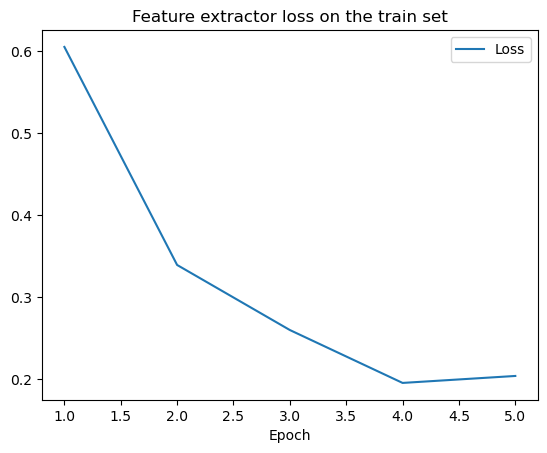

In [16]:
plt.title('Feature extractor loss on the train set')
plt.plot(np.arange(1,epoch_nums+1),train_loss_list,label='Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [17]:
trainloader2 = DataLoader(train_set, 128, shuffle=True)
testloader2 = DataLoader(test_set, 64, shuffle=True)
for p in alex_model2.features.parameters():
    p.requires_grad=False

epoch_nums = 5## Number of epochs
train_loss_list=[]
train_acc_list=[]
for epoch in range(epoch_nums):  # loop over the dataset multiple times
    gpu_alex_model2.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader2, 0):
        images=data[0].to(device)
        my_classes=data[1].to(device)
        
        logits=gpu_alex_model2(images)
        loss=cross_entropy2(logits,my_classes)
        
        loss.backward()
        cross_entropy_optimizer2.step()
        cross_entropy_optimizer2.zero_grad()
        
        running_loss=running_loss+loss.item()/len(trainloader2)
    
    gpu_alex_model2.eval()
    correct=0
    total=0
    with torch.no_grad():
        for data in trainloader2:
            images=data[0].to(device)
            labels=data[1].to(device)
            predictions=torch.argmax(gpu_alex_model2(images),1)
            correct+=torch.sum(torch.eq(predictions,labels)).item()
            total+=len(predictions)
    train_acc_list.append(correct/total)

    print("Epoch: %i Running loss: %f"%(epoch+1,running_loss))
    train_loss_list.append(running_loss)

print('Finished Training')

Epoch: 1 Running loss: 0.212769
Epoch: 2 Running loss: 0.163581
Epoch: 3 Running loss: 0.162942
Epoch: 4 Running loss: 0.156476
Epoch: 5 Running loss: 0.151228
Finished Training


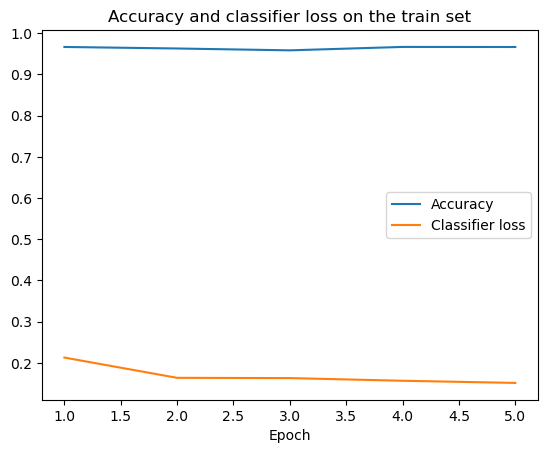

In [18]:
plt.title('Accuracy and classifier loss on the train set')
plt.plot(np.arange(1,epoch_nums+1),train_acc_list,label='Accuracy')
plt.plot(np.arange(1,epoch_nums+1),train_loss_list,label='Classifier loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [19]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
gpu_alex_model2.eval()
with torch.no_grad():
    for data in testloader2:
        images=data[0].to(device)
        labels=data[1].to(device)
        predictions=torch.argmax(gpu_alex_model2(images),1)
        correct+=torch.sum(torch.eq(predictions,labels)).item()
        total+=len(predictions)

print(f'Accuracy of the network on the 2000 test images: {100 * correct / total} %')

Accuracy of the network on the 2000 test images: 95.85 %


## Triplet loss full network training

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
triplet_train2=triplet_loss_cifar10_two_class(label1=0, label2=1, train=True, download=True, device=device, 
                                             transform=transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor()]))

alex_model3=alexnet(weights=AlexNet_Weights.IMAGENET1K_V1, progress=True)
for m in alex_model3.classifier.named_modules():
    if hasattr(m,'reset_parameters'):
        m.reset_parameters()
alex_model3.classifier[6]=nn.Linear(in_features=4096, out_features=2, bias=True)
cross_entropy3=nn.CrossEntropyLoss()
triplet_loss2=nn.TripletMarginLoss()
gpu_alex_model3=alex_model3.to(device)
optimizer3=torch.optim.Adam(gpu_alex_model3.parameters())
triplet_loader2 = DataLoader(triplet_train2, 128, shuffle=True)

Files already downloaded and verified


In [7]:
trainloader3 = DataLoader(train_set, 128, shuffle=True)
testloader3 = DataLoader(test_set, 64, shuffle=True)
epoch_nums = 10 ## Number of epochs
train_loss_list=[]
train_acc_list=[]
for epoch in range(epoch_nums):  # loop over the dataset multiple times
    gpu_alex_model3.train()
    running_loss = 0.0
    for data in triplet_loader2:
        (anchor, pos, neg, anchor_label, pos_label, neg_label)=data
        
        pos_out=gpu_alex_model3.features.forward( (pos.to(device)) ) 
        neg_out=gpu_alex_model3.features.forward( (neg.to(device)) )
        anchor_out=gpu_alex_model3.features(anchor.to(device))

        logits_pos=gpu_alex_model3.classifier.forward(torch.flatten(gpu_alex_model3.avgpool.forward(pos_out),1))
        logits_neg=gpu_alex_model3.classifier.forward(torch.flatten(gpu_alex_model3.avgpool.forward(neg_out),1))
        logits_anchor=gpu_alex_model3.classifier.forward(torch.flatten(gpu_alex_model3.avgpool.forward(anchor_out),1))
        loss_pos=cross_entropy3(logits_pos,pos_label.to(device).type(torch.int64))
        loss_neg=cross_entropy3(logits_neg,neg_label.to(device).type(torch.int64))
        loss_anchor=cross_entropy3(logits_anchor,anchor_label.to(device).type(torch.int64))
        
        loss1=triplet_loss2(anchor_out.flatten(start_dim=1),pos_out.flatten(start_dim=1),neg_out.flatten(start_dim=1))
        loss2=1/3*(loss_pos+loss_neg+loss_anchor)

        loss=loss1+loss2
        loss.backward()
        
        optimizer3.step()
        optimizer3.zero_grad()
        
        running_loss=running_loss+loss.item()/len(triplet_loader2)
    gpu_alex_model3.eval()
    correct=0
    total=0
    with torch.no_grad():
        for data in trainloader3:
            images=data[0].to(device)
            labels=data[1].to(device)
            predictions=torch.argmax(gpu_alex_model3(images),1)
            correct+=torch.sum(torch.eq(predictions,labels)).item()
            total+=len(predictions)
    train_acc_list.append(correct/total)
    print("Epoch: %i Running loss: %f"%(epoch+1,running_loss))
    train_loss_list.append(running_loss)


print('Finished Training the full network')

Epoch: 1 Running loss: 1.381478
Epoch: 2 Running loss: 0.729770
Epoch: 3 Running loss: 0.472094
Epoch: 4 Running loss: 0.339217
Epoch: 5 Running loss: 0.277987
Epoch: 6 Running loss: 0.227650
Epoch: 7 Running loss: 0.141290
Epoch: 8 Running loss: 0.120296
Epoch: 9 Running loss: 0.095310
Epoch: 10 Running loss: 0.075835
Finished Training the full network


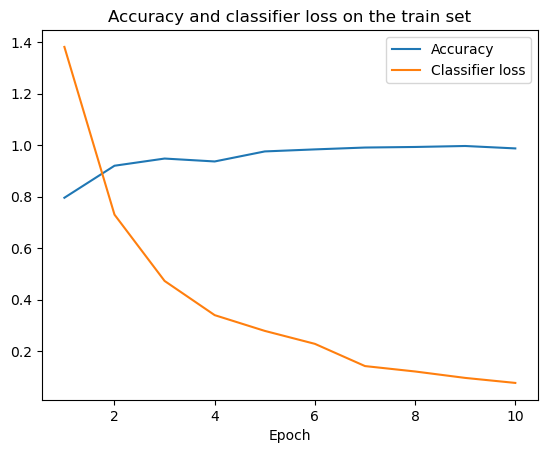

In [8]:
plt.title('Accuracy and classifier loss on the train set')
plt.plot(np.arange(1,epoch_nums+1),train_acc_list,label='Accuracy')
plt.plot(np.arange(1,epoch_nums+1),train_loss_list,label='Classifier loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [9]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
gpu_alex_model3.eval()
with torch.no_grad():
    for data in testloader3:
        images=data[0].to(device)
        labels=data[1].to(device)
        predictions=torch.argmax(gpu_alex_model3(images),1)
        correct+=torch.sum(torch.eq(predictions,labels)).item()
        total+=len(predictions)

print(f'Accuracy of the network on the 2000 test images: {100 * correct / total} %')

Accuracy of the network on the 2000 test images: 96.4 %


__Conclusion:__ We have achieved about 2% accuracy increase by using the triplet loss. Also, training the network as a whole yields the highest accuracy.